<a href="https://colab.research.google.com/github/m10singh94/CatDogClassification/blob/main/CatDogClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and Dog Classification

We will create a simple `TinyVGG model` and a `ViT model` to detect the class of image (either a dog or a cat), and try to demonstrate a demo of the model in Gradio in HuggingFace Space.

## 1 Starting with Importing all the files
* torch
* torchvision
* matplotlib
* torchinfo


In [ ]:
# importing torch and torchvision
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
from torchinfo import summary

from pathlib import Path
import os
import zipfile
import requests
import random
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## 2 Getting data

In [ ]:
# ! pip install -q kagglew

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

ref                                                                   title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                          Global Country Information Dataset 2023             23KB  2023-07-08 20:37:33          10944        429  1.0              
nelgiriyewithana/global-youtube-statistics-2023                       Global YouTube Statistics 2023                      60KB  2023-07-28 15:36:38           3053        120  1.0              
joebeachcapital/global-earth-temperatures                             Global Earth Temperatures                           33KB  2023-08-09 06:21:51            631         28  1.0              
joebeachcapital/top-500-hollywood-m

In [ ]:
! kaggle datasets download -d tongpython/cat-and-dog

 92% 201M/218M [00:01<00:00, 156MB/s]
100% 218M/218M [00:01<00:00, 152MB/s]


In [ ]:
data_path = Path("data/")
image_path = data_path / "cat_dog"

if image_path.is_dir():
  print(f"{image_path} exists.")
else:
  print(f"{image_path} doesn't exist, creating one.")
  image_path.mkdir(parents=True, exist_ok=True)

  # As dataset's already downloaded, changing the dirctory
  !mv ./cat-and-dog.zip ./data/cat_dog/cat-and-dog.zip

with zipfile.ZipFile(image_path / "cat-and-dog.zip", "r") as zip_ref:
  print("Unzipping cat and dog...")
  zip_ref.extractall(image_path)
  print("Unzipping completed!")

# clearing the directory
## removing the nesting of test and train folders to get directly to test and train folders under cat_dog folder
!mv ./data/cat_dog/test_set/test_set ./data/cat_dog/test
!mv ./data/cat_dog/training_set/training_set/ ./data/cat_dog/train

## removing all the empty folders and unnecessary files
!rmdir ./data/cat_dog/test_set ./data/cat_dog/training_set
!rm ./data/cat_dog/cat-and-dog.zip
!rm ./data/cat_dog/test/cats/_DS_Store ./data/cat_dog/test/dogs/_DS_Store ./data/cat_dog/train/cats/_DS_Store ./data/cat_dog/train/dogs/_DS_Store

print("Directory ready to use!")

data/cat_dog doesn't exist, creating one.
Unzipping cat and dog...
Unzipping completed!
Directory ready to use!


In [ ]:
# Setup training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/cat_dog/train'), PosixPath('data/cat_dog/test'))

## 3 Visualising and exploring random images from the directory

Image path: data/cat_dog/train/dogs/dog.1041.jpg
Image class: dogs
Image height: 465
Image width: 500


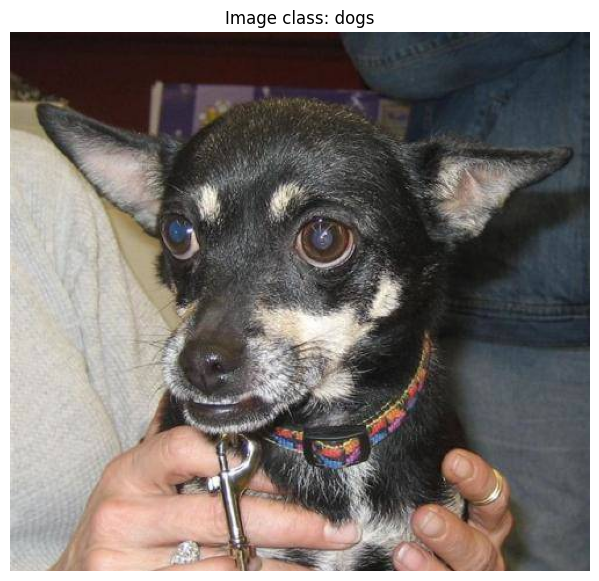

In [ ]:
# getting all the paths in a list
image_path_list = list(image_path.glob("*/*/*.jpg"))
# choosing a random path
random_image_path = random.choice(image_path_list)
# getting the class of the image
image_class = random_image_path.parent.stem
# open the image
img = Image.open(random_image_path)

print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img_arr = np.array(img)

# plot the figure using matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_arr)
plt.title(f"Image class: {image_class}")
plt.axis(False);

# (A) TinyVGG Model

## 4 Transforming data to make it suitable to be used in DataLoaders

### 4.1 Transform Data using `torchvision.transforms` module

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225],)
])

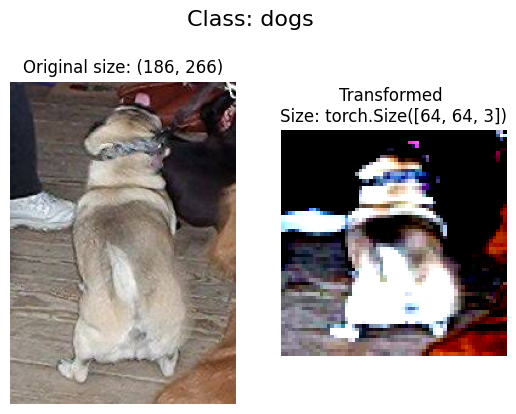

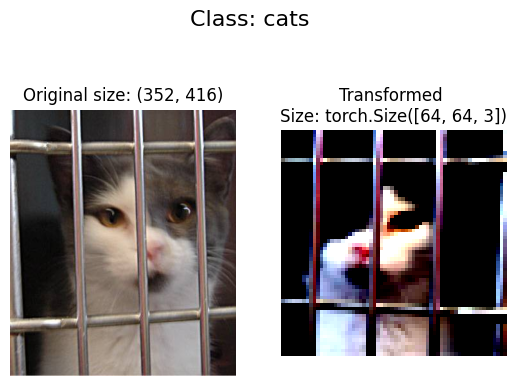

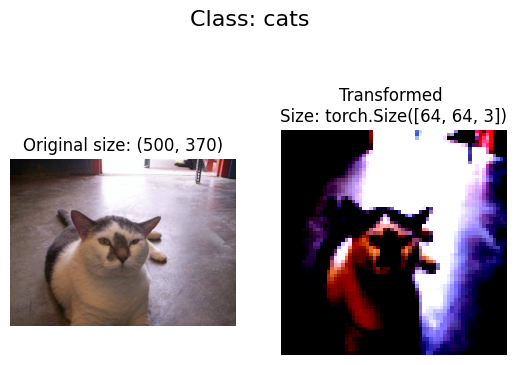

In [ ]:
from typing import List
def visualise_random_transformed_images(image_paths: List,
                                       transform: torchvision.transforms,
                                       n:int=3):
  """Plots n images with their transformed images alongside.

  Args:
    image_paths: list of all the image paths.
    transform: transform that needs to be applied to the images.
    n: number of samples
  """

  random_image_paths = random.sample(image_paths, k=n)

  for path in random_image_paths:
    with Image.open(path) as f:
      # plottign the original image
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original size: {f.size}")
      ax[0].axis("off")

      # plotting the transformed image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {path.parent.stem}", fontsize=16)

visualise_random_transformed_images(image_paths=image_path_list,
                                   transform=data_transform,
                                   n=3)

### 4.2 Converting Images to `Dataset`

In [ ]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\n\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8005
    Root location: data/cat_dog/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 2023
    Root location: data/cat_dog/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
class_names = train_data.classes
class_names

['cats', 'dogs']

In [ ]:
len(train_data), len(test_data)

(8005, 2023)

### 4.3 Converting `Dataset` to `torch.utils.data.DataLoader`

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b19b842ed70>,
 <torch.utils.data.dataloader.DataLoader at 0x7b19b842ed10>)

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
Label: 1


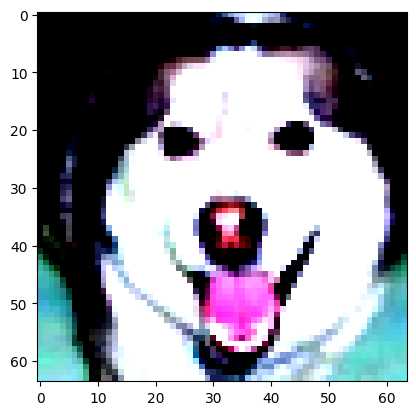

In [ ]:
img, label = next(iter(train_dataloader))
img_permuted = img[0,:,:,:]

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

# print a sample from the batch
plt.imshow(img_permuted.permute(1,2,0))
print(f"Label: {label[0]}")

## 5 Creating model

In [ ]:
from torch.nn.modules.dropout import Dropout2d
from torch.nn.modules.pooling import MaxPool2d
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.Conv2d_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(num_features=hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(num_features=hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2),
        nn.Dropout(0.2)
    )
    self.Conv2d_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(num_features=hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(num_features=hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1),
        nn.Dropout(0.2)
    )
    self.classifier_block = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*31*31,
                  out_features=output_shape)
    )

  def forward(self, x:torch.Tensor):
    return self.classifier_block(self.Conv2d_block2(self.Conv2d_block1(x)))

## 6 Training and Testing model

In [ ]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optim:torch.optim.Optimizer,
               device:torch.device):
  """
  This function trains the model.

  Args:
    model: model that needs to be trained
    dataloader: train dataloader
    loss_fn: loss function to be used for training
    optim: optimizer to be used for training
    device: "cuda" if available, otherwise "cpu"

  Returns:
    train_loss, train_acc: train loss, train accuracy
  """
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)#y.unsqueeze(1).float().to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optim.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optim.step()

    # predicting class
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

    # accumulating accuracy
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # calculating loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [ ]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device):
  """
  This function tests the model.

  Args:
    model: model that needs to be trained
    dataloader: test dataloader
    loss_fn: loss function to be used for training
    device: "cuda" if available, otherwise "cpu"

  Returns:
    test_loss, test_acc: test loss, test accuracy
  """
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)#y.unsqueeze(1).float().to(device)

      test_pred = model(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss.item()

      test_pred_labels = test_pred.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optim:torch.optim.Optimizer,
          loss_fn:torch.nn.Module = nn.BCEWithLogitsLoss,
          epochs:int=50,
          device:torch.device="cpu"):
  """
  This function combines the training and testing the model.

  Args:
    model: model that needs to be trained
    train_dataloader: train dataloader
    test_dataloader: test dataloader
    loss_fn: loss function to be used for training
    epochs: number of epochs for training
    device: "cuda" if available, otherwise "cpu"

  Returns:
    results: dictionary of train loss, test loss, train accuracy and test
    accuracy
  """

  results = {"train_loss": [],
             "test_loss": [],
             "train_acc": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optim=optim,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch+1}  | "
          f"Train_loss: {train_loss:.4f} | "
          f"Train_acc: {train_acc*100:.2f}% | "
          f"Test_loss: {test_loss:.4f} | "
          f"Test_acc: {test_acc*100:.2f}%")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = TinyVGG(input_shape=3,
                hidden_units=8,
                output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=0.001)

start_time = timer()
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optim=optim,
                      loss_fn=loss_fn,
                      epochs=40,
                      device=device)
end_time = timer()
print(f"Total training time: {(end_time-start_time)/60:.3f} min")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1  | Train_loss: 0.8154 | Train_acc: 59.23% | Test_loss: 0.7614 | Test_acc: 60.38%
Epoch: 2  | Train_loss: 0.6815 | Train_acc: 66.19% | Test_loss: 0.7353 | Test_acc: 62.28%
Epoch: 3  | Train_loss: 0.6073 | Train_acc: 68.75% | Test_loss: 0.5686 | Test_acc: 71.35%
Epoch: 4  | Train_loss: 0.5600 | Train_acc: 71.45% | Test_loss: 0.5356 | Test_acc: 73.74%
Epoch: 5  | Train_loss: 0.5418 | Train_acc: 73.31% | Test_loss: 0.5364 | Test_acc: 75.43%
Epoch: 6  | Train_loss: 0.5218 | Train_acc: 74.47% | Test_loss: 0.5819 | Test_acc: 69.52%
Epoch: 7  | Train_loss: 0.5159 | Train_acc: 75.02% | Test_loss: 0.5292 | Test_acc: 74.50%
Epoch: 8  | Train_loss: 0.4913 | Train_acc: 76.48% | Test_loss: 0.4996 | Test_acc: 76.56%
Epoch: 9  | Train_loss: 0.4802 | Train_acc: 77.62% | Test_loss: 0.5068 | Test_acc: 75.53%
Epoch: 10  | Train_loss: 0.4659 | Train_acc: 77.68% | Test_loss: 0.4731 | Test_acc: 77.66%
Epoch: 11  | Train_loss: 0.4613 | Train_acc: 78.29% | Test_loss: 0.4738 | Test_acc: 77.43%
Epoch: 1

## 7 Plotting losses and accuracies

In [ ]:
from typing import Dict
def plot_loss_acc_curves(model_results: Dict):
  """
  Plots the Loss curve and accuracy curve for the model.

  Args:
    model_results: Dictionary of Training loss, Test loss, Training accuracy
    and Test accuracy
  """
  epochs_list = list(range(len(model_results['train_loss'])))

  train_loss = model_results['train_loss']
  test_loss = model_results['test_loss']

  train_acc = model_results['train_acc']
  test_acc = model_results['test_acc']

  plt.figure(figsize=(15, 7))

  plt.subplot(1,2,1)
  plt.plot(epochs_list, train_loss, color='blue', label="Train Loss")
  plt.plot(epochs_list, test_loss, color='red', label="Test Loss")
  plt.title(f"Loss Curve")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs_list, train_acc, color='blue', label="Train Accuracy")
  plt.plot(epochs_list, test_acc, color='red', label="Test Accuracy")
  plt.title(f"Accuracy Curve")
  plt.xlabel("Epochs")
  plt.legend()

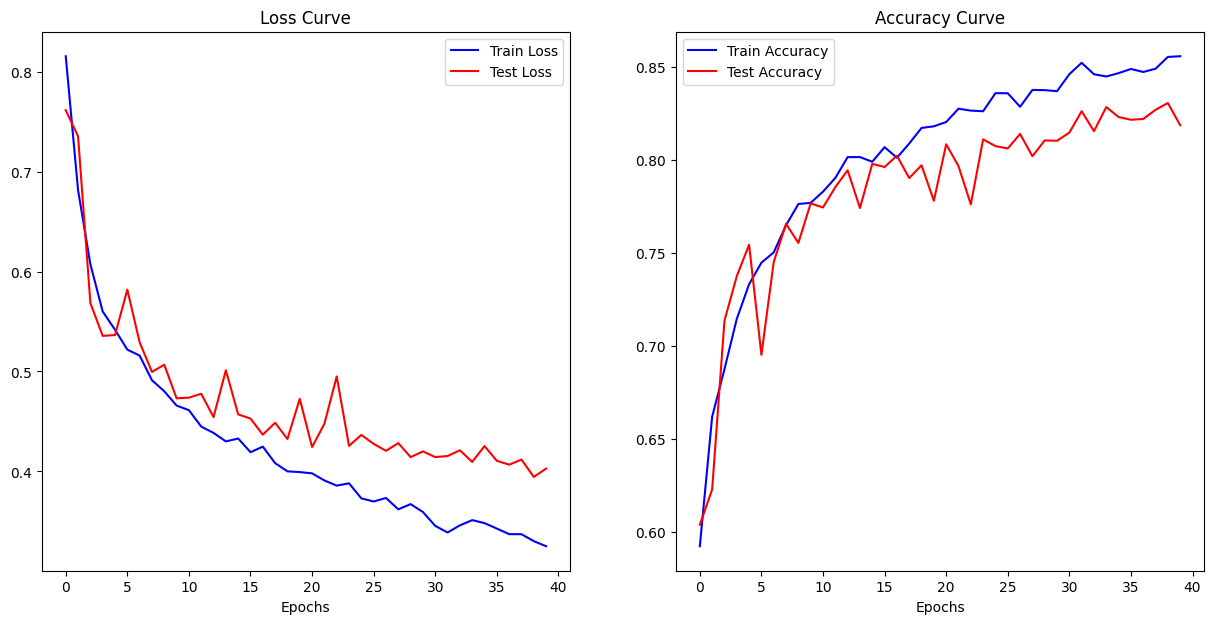

In [ ]:
plot_loss_acc_curves(model_results)

## 8 Infer a random figure

(-0.5, 499.5, 373.5, -0.5)

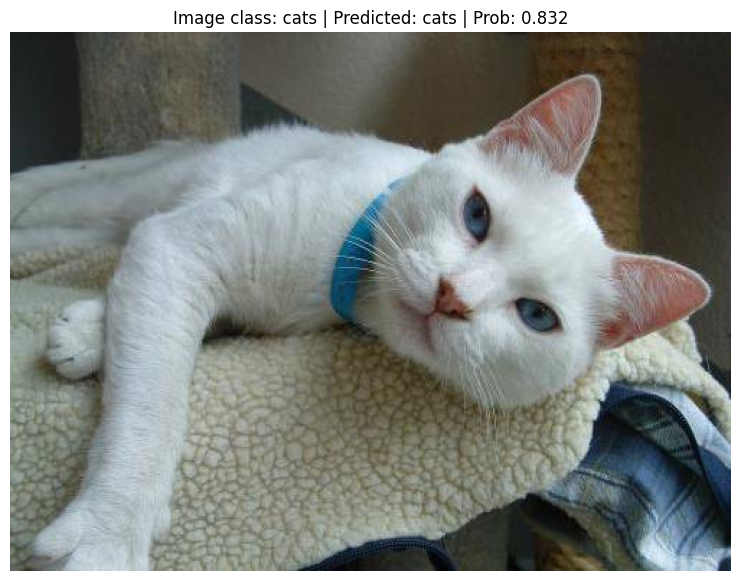

In [ ]:
# Get list of all the paths
image_paths = list(image_path.glob("*/*/*.jpg"))
# choosing a random path
random_image_path = random.choice(image_paths)
# getting the class of the image
image_class = random_image_path.parent.stem
# open the image
img = Image.open(random_image_path)

# Predicting the image
## Transforming the image
img_transformed = data_transform(img)
model.eval()
with torch.inference_mode():
  y_hat = model(img_transformed.unsqueeze(0).to(device))
  prob = y_hat.softmax(dim=1)
  predicted_label = y_hat.argmax(dim=1)

img_arr = np.array(img)

# plot the figure using matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_arr)
plt.title(f"Image class: {image_class} | Predicted: {class_names[predicted_label.cpu()]} | Prob: {prob.max().cpu():.3f}")
plt.axis(False)

In [ ]:
from typing import List
import math
def infer_random_images(image_paths: List,
                        model: torch.nn.Module,
                        transform: torchvision.transforms,
                        class_names: List,
                        n:int=6):
  """Plots n images to get their inference.

  Args:
    image_paths: list of all the image paths.
    transform: transform that needs to be applied to the images.
    class_names: list of class names.
    n: number of samples.
  """

  random_image_paths = random.sample(image_paths, k=n)

  fig = plt.figure(figsize=(15, 7))
  row = n//2
  col = math.ceil(n/row)

  for i,path in enumerate(random_image_paths):
    f = Image.open(path)
    image_class = path.parent.stem
    img_transformed = transform(f)
    model.eval()
    with torch.inference_mode():
      y_hat = model(img_transformed.unsqueeze(0).to(device))
      prob = y_hat.softmax(dim=1)
      predicted_label = y_hat.argmax(dim=1)

    img_arr = np.array(f)
    fig.add_subplot(row, col, i+1)
    plt.imshow(img_arr)
    plt.axis("off")
    plt.title(f"Image class: {image_class} | Predicted: {class_names[predicted_label.cpu()]} | Prob: {prob.max().cpu():.3f}")

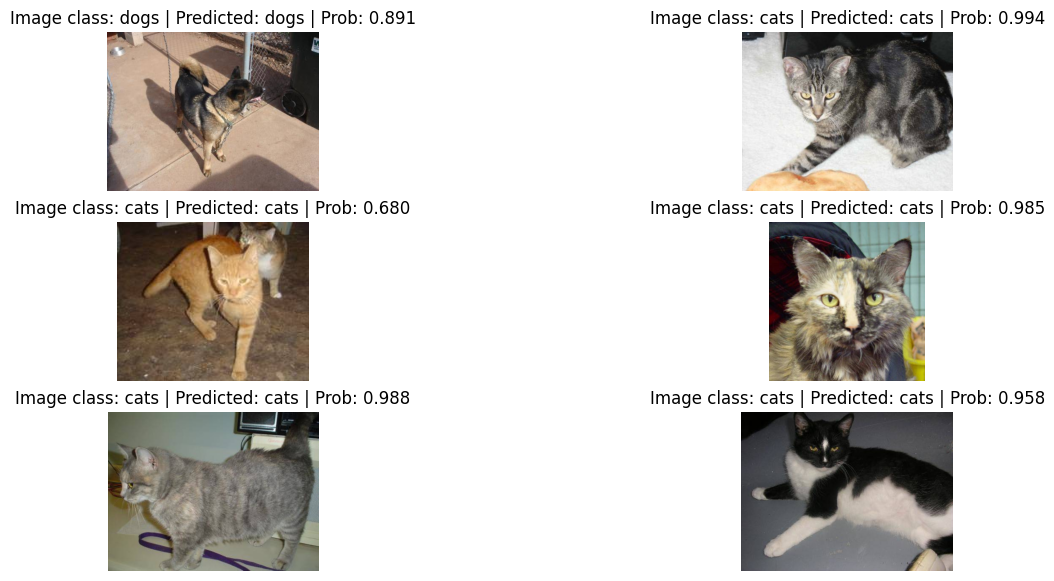

In [ ]:
infer_random_images(image_paths=image_paths,
                    model=model,
                    transform=data_transform,
                    class_names=class_names,
                    n=6)

## 9 Save the model



In [ ]:
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include either ".pth" or ".pt" as the file extension.
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)
  print(f"Model Saved!!")

In [ ]:
save_model(model=model,
           target_dir="models",
           model_name="tinyvgg_model.pth")

[INFO] Saving model to: models/tinyvgg_model.pth
Model Saved!!


# (B) ViT Model

## 4 Creating Model, Transforms and DataLoader

### 4.1 Creating ViT model and adding weights

In [ ]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit = torchvision.models.vit_b_16(weights=vit_weights)

for parameter in vit.parameters():
  parameter.requires_grad = False

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 121MB/s]


In [ ]:
# changing the out_features as per our requirement
torch.manual_seed(42)
torch.cuda.manual_seed(42)

vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 4.2 Transforming Data using ViT model transform module

In [ ]:
# Get transforms from pretrained ViT weights
vit_transforms = vit_weights.transforms()
print(vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 4.3 Creating Dataset

In [ ]:
train_data_vit = datasets.ImageFolder(root=train_dir,
                                  transform=vit_transforms,
                                  target_transform=None)
test_data_vit = datasets.ImageFolder(root=test_dir,
                                 transform=vit_transforms)

print(f"Train data:\n{train_data}\n\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8005
    Root location: data/cat_dog/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 2023
    Root location: data/cat_dog/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


### 4.4 Converting Dataset to `torch.utils.data.DataLoader`

In [ ]:
train_dataloader_vit = DataLoader(dataset=train_data_vit,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader_vit = DataLoader(dataset=test_data_vit,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)
train_dataloader_vit, test_dataloader_vit

(<torch.utils.data.dataloader.DataLoader at 0x7b19b28d9480>,
 <torch.utils.data.dataloader.DataLoader at 0x7b19b28d9e40>)

## 5 Train and test the model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=vit.parameters(), lr=0.001)

start_time = timer()
model_results_vit = train(model=vit,
                      train_dataloader=train_dataloader_vit,
                      test_dataloader=test_dataloader_vit,
                      optim=optim,
                      loss_fn=loss_fn,
                      epochs=5,
                      device=device)
end_time = timer()
print(f"Total training time: {(end_time-start_time)/60:.3f} min")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  | Train_loss: 0.0535 | Train_acc: 98.87% | Test_loss: 0.0240 | Test_acc: 99.41%
Epoch: 2  | Train_loss: 0.0172 | Train_acc: 99.61% | Test_loss: 0.0220 | Test_acc: 99.46%
Epoch: 3  | Train_loss: 0.0125 | Train_acc: 99.71% | Test_loss: 0.0226 | Test_acc: 99.41%
Epoch: 4  | Train_loss: 0.0101 | Train_acc: 99.76% | Test_loss: 0.0218 | Test_acc: 99.51%
Epoch: 5  | Train_loss: 0.0081 | Train_acc: 99.83% | Test_loss: 0.0224 | Test_acc: 99.41%
Total training time: 9.681 min


## 6 Plotting Loss and Accuracy Curves

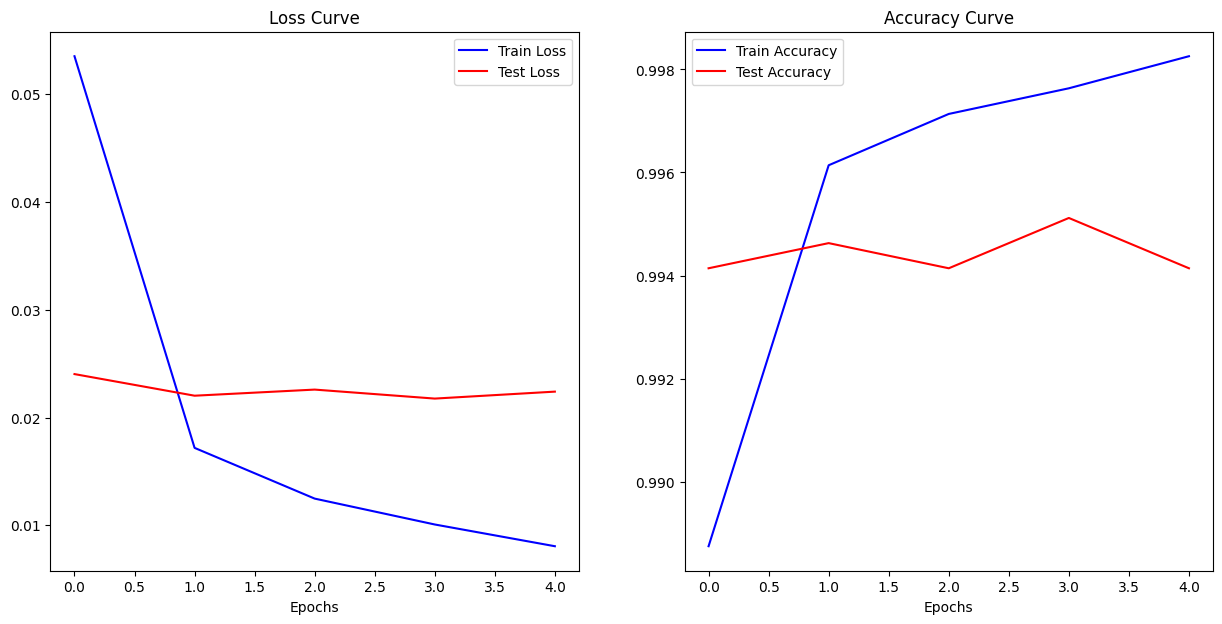

In [ ]:
plot_loss_acc_curves(model_results_vit)

## 7 Infer random pictures

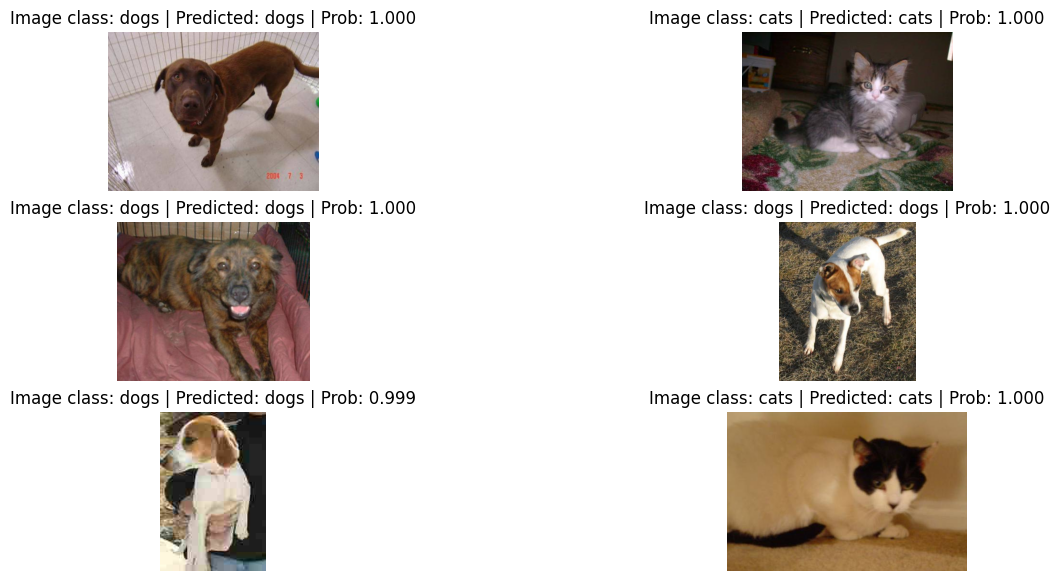

In [ ]:
infer_random_images(image_paths=image_paths,
                    model=vit,
                    transform=vit_transforms,
                    class_names=class_names,
                    n=6)

## 8 Save the model

In [ ]:
save_model(model=vit,
           target_dir="models",
           model_name="vit_model.pth")

[INFO] Saving model to: models/vit_model.pth
Model Saved!!


## 9 Downloading a random picture from net and inferring the class

In [ ]:
import requests
def download_random_img(image_link: str):
  """
  Takes in the image link and downloads it in the 'data_path'

  Args:
    image_link: link of teh image to be downloaded

  Returns:
    random_image_path: path of the downloaded image
  """
  random_image_path = data_path / "random_image.jpeg"
  with open(random_image_path, "wb") as f:
    request = requests.get(image_link)
    print(f"Downloading image...")
    f.write(request.content)
    print(f"Image downloaded!")
    return random_image_path

In [ ]:
def predict_random_img(image_link: str,
                     model: torch.nn.Module,
                     class_names: List[str] = None,
                     transform=None,
                     device: torch.device = device):
  """
  Downloads the image from the image link and infers the class of teh image
  with the probability of the prediction.

  Args:
    image_link: link of the image that you want to download ("image address")
    model: model with which prediction has to be done
    class_names: list of the possible categories for this classification
    transform: transformations needed for this image to be put inside the model
    device: "cuda" if available, otherwise "cpu"
  """
  # downloading the image
  image_path = download_random_img(image_link)
  # opening the image
  target_image = Image.open(image_path)
  target_image_transformed = transform(target_image)

  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_image_transformed = target_image_transformed.unsqueeze(dim=0)
    target_image_pred = model(target_image_transformed.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # printing the image with the class and its probability
  img_arr = np.array(target_image)
  plt.imshow(img_arr)
  title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False);

Image downloaded!


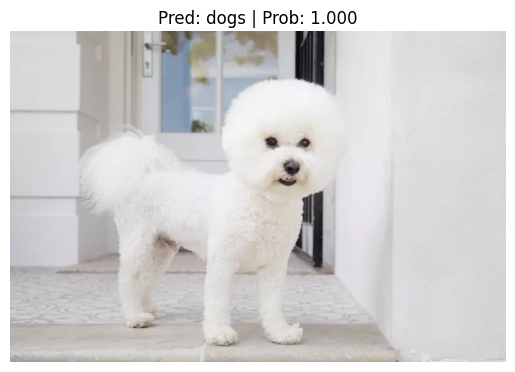

In [ ]:
image_link="https://www.thesprucepets.com/thmb/oKHfiSNNXsEMtbGrQEhsjphiCx4=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/white-dog-breeds-4846529-hero-4bf084c93c5b45a292e30559bb7e50e8.jpg"
predict_random_img(image_link=image_link
                 model=vit,
                 class_names=class_names,
                 transform=vit_transforms)